## Lindgren, Eric
## 970222-1954

In [14]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set("talk") # for plot formatting

import scipy.optimize as opt

# Problem 5

## Task a)

Text(0.5, 1.0, 'Generated data')

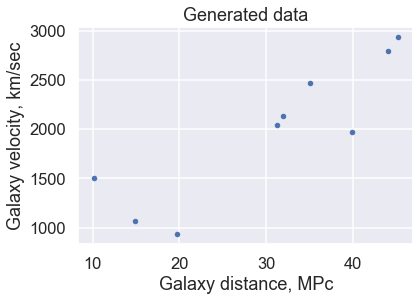

In [63]:
# Data from student lab observations; 
# x = Galaxy distances in MPc
# y = Galaxy velocity in km/sec
x = np.array([10.1 ,45.2, 19.7, 31.2, 31.9, 44.0,
       14.9, 35.1,  39.9  ])
y = np.array([1507.9, 2937.5,  930.4, 2037.1, 2131.1,
       2795.6, 1061.8, 2464.8, 
       1971.1])
sigma = 200

# Plot data
fig, ax = plt.subplots()
ax.plot(x,y, 'b.', label='Data')
ax.set_xlabel("Galaxy distance, MPc")
ax.set_ylabel("Galaxy velocity, km/sec")
plt.title("Generated data")

No error on x, and a constant standard deviation of $\sigma$ on y. This makes the probability to measure a certain datapoint to be normally distributed around the model value: 

$$p(x_i,y_i|M, I) \sim N(y_M(x_i;\theta), \sigma) $$

where $\theta$ are the model parameters. The total likelihood is thus:

$$ \log{p(D|M,I)} = \log{\prod_{i=0}^{N-1}p(x_i, y_i|M,I)} = -N \log{\sqrt{2\pi\sigma^2}} + \sum_{i=0}^{N-1} \frac{-[y_i-y_M(x_i;\theta)]}{2\sigma^2}  $$

We make the prior that the data can be fitted with a straight line. Thus our model $M$ only has two parameters in $\theta$: the intercept $m$ and the slope $k$. Hubbles law states that $y = H_0 \cdot x$, which means that we are only really interested in $k$.

#### Step 1: Maximum likelihood estimate

In [56]:
# return a simple maximum likelihood estimate
def log_likelihood(theta, x, y, sigma):
    term_1 = -len(x)*np.log(2*np.pi*sigma**2)
    y_M = theta[0]*np.ones((len(x))) + theta[1]*x
    term_2 = (-(y-y_M)**2/(2*sigma**2)).sum()
    return term_1 + term_2


def negative_log_likelihood(theta,x,y,sigma):
    return -log_likelihood(theta, x, y, sigma)

# Maximize using scipy optimize
max_like_est = opt.minimize(negative_log_likelihood, [0,0], args=(x, y, sigma))
display(f'Maximum likelihood approach yields: m, k={max_like_est.x}')

'Maximum likelihood approach yields: m, k=[506.32926036  48.824909  ]'

The maximum likelihood estimate for the Hubble constant is $H_0 \approx 48.8$.

#### Step 2: Bayesian analysis

In [60]:
# define log of prior, use log likelihood from step 1. We do not care 
# about the normalization in Bayes theorem.
def log_prior_intercept(m, sigma):
    fun = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-(np.abs(m)**2)/(2*sigma**2))
    return np.log(fun)


def log_prior_slope(k):
    fun =  1/(1+k**2)**(3/2)
    return np.log(fun)


def log_posterior(theta, x, y, sigma):
    log_like = log_likelihood(theta, x, y, sigma)
    # Assume m and k to be independent. Then their joint pdf is the product
    # of the two.
    log_prior = log_prior_intercept(theta[0],sigma) + log_prior_slope(theta[1])
    return log_like + log_prior


def negative_log_posterior(theta, x, y, sigma):
    return -log_posterior(theta,x,y,sigma)

# We want to maximize these and find their respective modes. Especially 
# for the slope.
# Use scipy optimize as in step 1 again:
max_bayesian_approach = opt.minimize(negative_log_posterior, [0,0], args=(x, y, sigma))
display(f'Bayesian approach yields: m, k={max_bayesian_approach.x}')

'Bayesian approach yields: m, k=[306.45253168  54.31160937]'

#### Step 3: Bayesian approach to Outliers (good-data/bad-data)

In [90]:
def complicated_likelihood(m, k, eps, g, x, y, sigma):
    # eps, g, x and y are all vectors
    y_M = m*np.ones((len(x))) + k*x
    gauss = 1/np.sqrt(2*np.pi*eps**2)*np.exp(-((y_M-y)**2)/(2*eps**2))
    lorentz = 1/(np.sqrt(2)*np.pi*sigma)*1/(1+((y_M-y)**2)/(2*sigma**2))
    return g*(gauss) + (np.ones((len(g)))-g)*lorentz


def log_complicated_likelihood(eps, g, m, k, x, y, sigma):
    return np.log(complicated_likelihood(m, k, eps, g, x, y, sigma))


eps = np.ones((len(x)))*1e3
g = np.ones((len(x)))
k = 2,
m = 1 
#print(complicated_likelihood(m, k, eps, g, x, y, sigma))

# Use an emcee sampler to explore the parameter space for this pdf. 
# Study the log of this pdf
import emcee

ndim = 2  # epsilon, m, k, g TODO include m and k
nwalkers = 10  # nbr of mcmc walkers
# Randomize the starting position in epsilon and g space
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
# Define the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_complicated_likelihood, args=[m, k, x, y, sigma])
# Burn-in
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()
# Start the walk
sampler.run_mcmc(pos, 1000)
print(EnsembleSampler.chain)
# Marginalize out epsilon, m and g - plot pdf for k, our desired parameter


emcee: Exception while calling your likelihood function:
  params: [0.6161296  0.44348427]
  args: [1, (2,), array([10.1, 45.2, 19.7, 31.2, 31.9, 44. , 14.9, 35.1, 39.9]), array([1507.9, 2937.5,  930.4, 2037.1, 2131.1, 2795.6, 1061.8, 2464.8,
       1971.1]), 200]
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Miniconda3\envs\physics\lib\site-packages\emcee\ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: log_complicated_likelihood() missing 1 required positional argument: 'sigma'


TypeError: log_complicated_likelihood() missing 1 required positional argument: 'sigma'